# Problem Statement

#### Upgrade propensity model

In this task, we ask you to do an analysis to predict what customers will be most likely to upgrade
We provide a small sample of data you build the propensity model with, please note that this is dummy data but similar in construct to data you may be working with.
You will use this dataset to build your model.

#### Task list
- Data exploration, data cleaning and feature engineering. Remember to comment each step properly.
- Explanatory analysis. Include key insights in the presentation
- Modelling/Training
- Prepare a presentation for both a data science and a business audience and present the analysis to both, this will be the first part of the interview. Use visualisations and tell compelling stories. Tell us what is the message(s) for the business? What actionable insights you can provide to the business?
- Don’t limit yourself to the requested tasks. 

#### Required Output
- Fully commented code 
- Modelling dataset (CSV file)
- Visualisation tool files (if anything)
- Slides of presentations, including but not limited to:
    - Problem statement, Assumptions, Hypotheses
    - Exploratory analysis
    - Modelling approach
    - Results
        - Model performance measures
        - Business audience performance measures
        - Insights
    - Recommendations

# Data Exploration and Preparation

## Loading the data

- This section includes loading of the data, understanding basic description of the data; followed by cleanup & imputations if required.

In [938]:
# Importing the required packages

import random
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from collections import Counter

%matplotlib inline

from sklearn.model_selection import train_test_split
import category_encoders as ce


# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,f1_score, precision_recall_curve,auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, RepeatedStratifiedKFold
from IPython.display import display
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# import pickle

In [894]:
# Loading at the data and looking at the shape

data = pd.read_excel(r'data/DATA.xlsx')
print('Shape of data is:', data.shape)
upgrades = pd.read_excel(r'data/UPGRADES.xlsx')
print('Shape of upgrades dataset is:', upgrades.shape)

Shape of data is: (10350, 18)
Shape of upgrades dataset is: (10350, 2)


In [895]:
data.head()

,SUBSCRIPTION_KEY,AVERAGE_SPEND,VOICE_OFFNET_CNT_L3M,VOICE_OFFNET_DUR_L3M,VOICE_OUTBOUND_ROAM_CNT_L3M,SMS_OFFNET_CNT_L3M,SMS_OUTBOUND_ROAM_CNT_L3M,DATA_CNT_L3M,DATA_VOLUME_L3M,NUM_OF_UPGRADES,HANDSET_FIRST_DATE,HANDSET_LATEST_DATE,LOYALTY_FLAG,SEGMENT,TOPUP_VALUE_L3M,TOPUP_CNT_L3M,CALLS_CARE_CNTS_L6M,AUTO_TOPUP
0,462713,2.71,6,283,0.0,2,0.0,0.0,0.0,2.0,2015-09-26,2016-01-07,No,Segment3,8.1301,1.0,0.0,N
1,272924,16.26,3,34,1.0,13,9.0,0.0,0.0,0.0,2015-07-24,2016-01-07,Yes,Segment4,48.7806,3.0,1.0,N
2,319500,5.42,15,"2,477",0.0,36,0.0,0.0,0.0,0.0,2012-09-04,2016-01-07,No,Segment2,16.2602,1.0,0.0,N
3,106425,16.26,8,"1,702",0.0,25,0.0,0.0,0.0,0.0,2014-10-10,2016-01-07,No,Segment4,48.7806,3.0,0.0,N
4,90315,2.71,2,106,0.0,25,0.0,0.0,0.0,0.0,2015-05-17,2016-01-07,No,Segment3,8.1301,1.0,0.0,N


In [896]:
upgrades.head()

,SUBSCRIPTION_KEY,UPGRADE_FLAG
0,462713,NO
1,272924,NO
2,319500,NO
3,106425,NO
4,90315,NO


In [897]:
# Merging upgrades info with data
data = pd.merge(data, upgrades, on='SUBSCRIPTION_KEY')

## Variable Identification

In [898]:
# Looking at individual features
data.dtypes

SUBSCRIPTION_KEY                        int64
AVERAGE_SPEND                         float64
VOICE_OFFNET_CNT_L3M                    int64
VOICE_OFFNET_DUR_L3M                   object
VOICE_OUTBOUND_ROAM_CNT_L3M           float64
SMS_OFFNET_CNT_L3M                     object
SMS_OUTBOUND_ROAM_CNT_L3M             float64
DATA_CNT_L3M                          float64
DATA_VOLUME_L3M                       float64
NUM_OF_UPGRADES                       float64
HANDSET_FIRST_DATE             datetime64[ns]
HANDSET_LATEST_DATE            datetime64[ns]
LOYALTY_FLAG                           object
SEGMENT                                object
TOPUP_VALUE_L3M                       float64
TOPUP_CNT_L3M                         float64
CALLS_CARE_CNTS_L6M                   float64
AUTO_TOPUP                             object
UPGRADE_FLAG                           object
dtype: object

In [899]:
# Checking the count of unique target values
print(Counter(data['UPGRADE_FLAG']))

Counter({'NO': 10000, 'YES': 350})


In [900]:
# Checking for unique values

data.nunique()

SUBSCRIPTION_KEY               10350
AVERAGE_SPEND                     58
VOICE_OFFNET_CNT_L3M             143
VOICE_OFFNET_DUR_L3M            2954
VOICE_OUTBOUND_ROAM_CNT_L3M       73
SMS_OFFNET_CNT_L3M               626
SMS_OUTBOUND_ROAM_CNT_L3M        114
DATA_CNT_L3M                       1
DATA_VOLUME_L3M                    1
NUM_OF_UPGRADES                    4
HANDSET_FIRST_DATE              1402
HANDSET_LATEST_DATE                1
LOYALTY_FLAG                       2
SEGMENT                            5
TOPUP_VALUE_L3M                  110
TOPUP_CNT_L3M                     12
CALLS_CARE_CNTS_L6M                9
AUTO_TOPUP                         2
UPGRADE_FLAG                       2
dtype: int64

In [901]:
# looking at nan values accross dataset

data.isna().sum().loc[lambda x : x>0]

AVERAGE_SPEND                  50
VOICE_OUTBOUND_ROAM_CNT_L3M    50
SMS_OUTBOUND_ROAM_CNT_L3M      50
DATA_CNT_L3M                   50
DATA_VOLUME_L3M                50
NUM_OF_UPGRADES                50
LOYALTY_FLAG                   50
SEGMENT                        50
TOPUP_VALUE_L3M                50
TOPUP_CNT_L3M                  50
CALLS_CARE_CNTS_L6M            50
AUTO_TOPUP                     50
dtype: int64

In [902]:
# finding frequencies in categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

print("Number of categorical variables:{}".format(len(categorical)))
print("The categorical variables are:",categorical)

for i in categorical:
    print(data[i].value_counts)
#     print(Counter(data[i]))

Number of categorical variables:6
The categorical variables are: ['VOICE_OFFNET_DUR_L3M', 'SMS_OFFNET_CNT_L3M', 'LOYALTY_FLAG', 'SEGMENT', 'AUTO_TOPUP', 'UPGRADE_FLAG']
<bound method IndexOpsMixin.value_counts of 0                                              283
1                                               34
2                                            2,477
3                                            1,702
4                                              106
                           ...                    
10345                                          253
10346                                            0
10347                                          249
10348                                        2,361
10349                                           36
Name: VOICE_OFFNET_DUR_L3M, Length: 10350, dtype: object>
<bound method IndexOpsMixin.value_counts of 0                                                2
1                                               13
2                     

In [903]:
# checking for duplicate records

print("Number of duplicate records are:{}".format(data.duplicated().sum()))

Number of duplicate records are:0


In [904]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SUBSCRIPTION_KEY,10350.0,238842.335362,137379.999580,4.0000,120194.2500,238182.0000,357392.2500,477531.0000
AVERAGE_SPEND,10300.0,10.210563,5.477842,1.3500,5.4200,10.8400,16.2600,46.0700
VOICE_OFFNET_CNT_L3M,10350.0,14.447729,21.641523,0.0000,0.0000,5.0000,19.0000,204.0000
VOICE_OUTBOUND_ROAM_CNT_L3M,10300.0,1.683107,7.276299,0.0000,0.0000,0.0000,0.0000,380.0000
SMS_OUTBOUND_ROAM_CNT_L3M,10300.0,2.631942,16.140975,0.0000,0.0000,0.0000,0.0000,681.0000
DATA_CNT_L3M,10300.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
DATA_VOLUME_L3M,10300.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
NUM_OF_UPGRADES,10300.0,0.071942,0.290927,0.0000,0.0000,0.0000,0.0000,3.0000
TOPUP_VALUE_L3M,10300.0,30.609399,16.508226,4.0569,16.2602,32.5204,48.7806,138.2117
TOPUP_CNT_L3M,10300.0,2.024951,1.051014,1.0000,1.0000,2.0000,3.0000,12.0000


In [905]:
# print(Counter(data['DATA_CNT_L3M']))
# print(Counter(data['DATA_VOLUME_L3M']))

# Dropping redundant and unnecessary columns, also dropping features with only single value
data.drop(['SUBSCRIPTION_KEY', 'DATA_CNT_L3M', 'DATA_VOLUME_L3M', 'TOPUP_VALUE_L3M', 'TOPUP_CNT_L3M'], axis=1, inplace=True)

#### Initial Observations:

- There are a total of 10350 records in the dataset with 10000 records set to 'NO' upgrade and the remaining 350 records set to 'YES'.
- At first glance, it is a binary classification problem with imbalance issue clearly visible.
- There are a total of 20 features and 1 target variable in the dataset.
- There are no duplicate records.
- There are no negative values as shown from the min values.
- The columns have different ranges and magnitudes which suggests that scaling could be required if distance based algorithms are used.
- There is definite skewness in few of the variables since there is a jump from min 0 compared to max.
- There are missing values visible but they range across different rows and columns. The missing value count of all variables is 50 which is peculiar.
- Dropping 'DATA_CNT_L3M', 'DATA_VOLUME_L3M' as they contain single values as they doesn't provide any variability for our analysis.
- Dropping TOPUP_VALUE_L3M and TOPUP_CNT_L3M as these are redundant columns and can be derived from AVERAGE SPEND.

## Missing value treatment

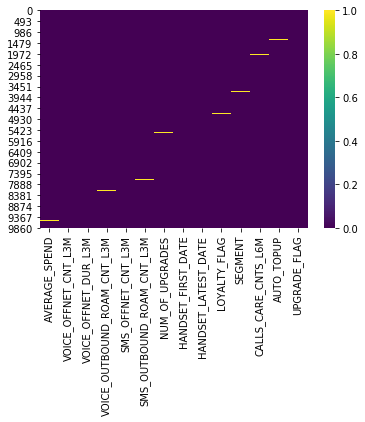

In [906]:
# Visualizing missing values across data

sns.heatmap(data.isnull(), cmap='viridis');

### Handling numerical columns with missing data

In [907]:
num_cols = [var for var in data.columns if data[var].dtype=='int64' or data[var].dtype=='float64']
data[num_cols].isna().sum().loc[lambda x : x>0]

AVERAGE_SPEND                  50
VOICE_OUTBOUND_ROAM_CNT_L3M    50
SMS_OUTBOUND_ROAM_CNT_L3M      50
NUM_OF_UPGRADES                50
CALLS_CARE_CNTS_L6M            50
dtype: int64

In [908]:
# Using mean imputation to impute float variables

num_nul_cols = ['AVERAGE_SPEND', 'VOICE_OUTBOUND_ROAM_CNT_L3M', 'SMS_OUTBOUND_ROAM_CNT_L3M']

data[num_nul_cols] = data[num_nul_cols].fillna(data[num_nul_cols].mean())

In [909]:
data.isna().sum().loc[lambda x: x>0]

NUM_OF_UPGRADES        50
LOYALTY_FLAG           50
SEGMENT                50
CALLS_CARE_CNTS_L6M    50
AUTO_TOPUP             50
dtype: int64

### Handling nominal categorical columns with missing data

In [910]:
data['VOICE_OFFNET_DUR_L3M'] = data['VOICE_OFFNET_DUR_L3M'].str.strip()
data['VOICE_OFFNET_DUR_L3M'] = data['VOICE_OFFNET_DUR_L3M'].str.replace(',','',regex=True)
data['VOICE_OFFNET_DUR_L3M'] = data['VOICE_OFFNET_DUR_L3M'].apply(pd.to_numeric)
data['SMS_OFFNET_CNT_L3M'] = data['SMS_OFFNET_CNT_L3M'].str.strip()
data['SMS_OFFNET_CNT_L3M'] = data['SMS_OFFNET_CNT_L3M'].str.replace(',','',regex=True)
data['SMS_OFFNET_CNT_L3M'] = data['SMS_OFFNET_CNT_L3M'].apply(pd.to_numeric)

### Handling categorical columns with missing data

In [911]:
cat_cols = ['LOYALTY_FLAG', 'SEGMENT', 'AUTO_TOPUP']

for i in cat_cols:
    print(Counter(data[i]))

Counter({'No': 6952, 'Yes': 3348, nan: 50})
Counter({'Segment3': 4759, 'Segment1': 2242, 'Segment2': 1678, 'Segment4': 1597, nan: 50, 'UNKNOWN': 24})
Counter({'N': 10139, 'Y': 161, nan: 50})


In [912]:
# Imputing na with 'UNKNOWN' since this already exists and retaining it captures the importance of missingness
data['SEGMENT'] = data['SEGMENT'].fillna("UNKNOWN")

In [913]:
# Creating function to impute with most frequency category
def nan_freq_imputer(df,ColName):
     most_freq_cat=df[ColName].mode()[0]
    # replace nan values with most occured category
     df[ColName].fillna(most_freq_cat,inplace=True)

In [914]:
for col in ['LOYALTY_FLAG', 'AUTO_TOPUP', 'NUM_OF_UPGRADES', 'CALLS_CARE_CNTS_L6M']:
    nan_freq_imputer(data,col)

In [915]:
# for i in cat_cols:
#     print(Counter(data[i]))

#### Actions Taken:

- Missing value treatment is done using the below ways:
    - Numerical values: Mean imputation is performed to impute the missing values.
    - Categorical values: Frequency imputation is performed for 2 of them and since only feature already has the 'UNKNOWN' categorical these NA values are imputed with 'UNKNOWN'.

# Data Visualization

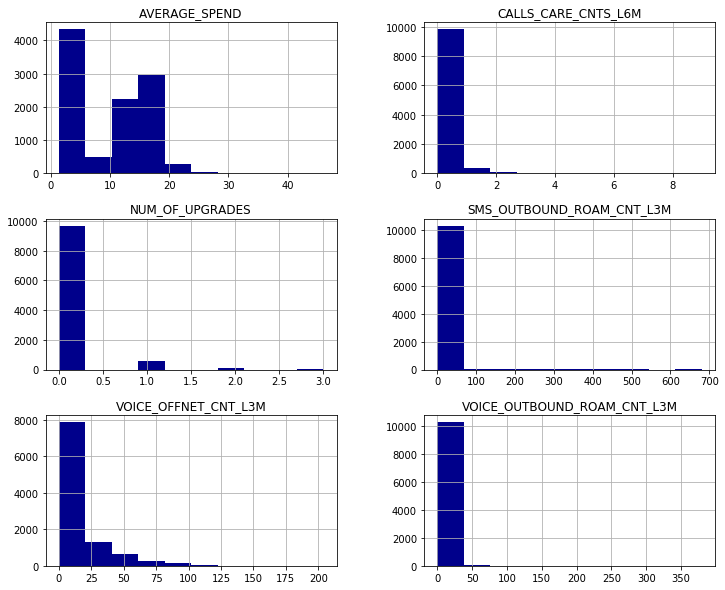

In [916]:
# sns.pairplot(data[num_cols]);
data[num_cols].hist(figsize=(12, 10), color='darkblue');

# Feature Engineering & Selection

In [917]:
# Replacing Yes, No to 1 and 0
data = data.replace({'LOYALTY_FLAG': {'Yes': 1, 'No': 0},
                    'AUTO_TOPUP': {'Y': 1, 'N': 0},
                   'UPGRADE_FLAG': {'YES': 1,'NO': 0},
                    'SEGMENT': {'Segment1': 1, 'Segment2': 2, 'Segment3': 3,
                        'Segment4': 4, 'UNKNOWN': 0}} )

# for i in cat_cols:
#     print(Counter(data[i]))

In [918]:
# Converting categorical feature 'SEGMENT' to dummies
# data = pd.get_dummies(data, columns=['SEGMENT'])

In [919]:
# Creating handset recency column
data['HANDSET_RECENCY'] = (data['HANDSET_LATEST_DATE']-data['HANDSET_FIRST_DATE']).dt.days

# Dropping date columns
data.drop(['HANDSET_FIRST_DATE','HANDSET_LATEST_DATE'], axis=1, inplace=True)

In [920]:
data.query('HANDSET_RECENCY < 0')

,AVERAGE_SPEND,VOICE_OFFNET_CNT_L3M,VOICE_OFFNET_DUR_L3M,VOICE_OUTBOUND_ROAM_CNT_L3M,SMS_OFFNET_CNT_L3M,SMS_OUTBOUND_ROAM_CNT_L3M,NUM_OF_UPGRADES,LOYALTY_FLAG,SEGMENT,CALLS_CARE_CNTS_L6M,AUTO_TOPUP,UPGRADE_FLAG,HANDSET_RECENCY
5,5.42,0,0,0.0,0,0.0,0.0,0,3,0.0,0,0,-999
1222,2.71,6,204,0.0,1,0.0,0.0,0,4,0.0,0,0,-999
1433,5.42,2,18,0.0,27,0.0,0.0,0,3,0.0,0,0,-999
1582,10.84,0,0,0.0,0,0.0,0.0,1,2,0.0,0,0,-999
1982,16.26,0,0,0.0,0,2.0,0.0,1,3,0.0,0,0,-999
2126,2.71,1,31,7.0,2,8.0,0.0,0,3,0.0,0,0,-999
2214,21.68,48,4991,0.0,26,0.0,0.0,0,3,0.0,0,0,-999
3161,1.36,0,0,0.0,0,0.0,0.0,0,3,0.0,0,0,-999
3424,5.42,10,5053,0.0,6,0.0,0.0,0,2,0.0,0,0,-999
3658,10.84,17,4175,0.0,2,0.0,0.0,0,2,0.0,0,1,-999


In [921]:
# Removing the rows with Hanset_Recency less than 0
data = data[data['HANDSET_RECENCY']>0]

In [922]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AVERAGE_SPEND,10325.0,10.215207,5.463613,1.35,5.42,10.84,16.26,46.07
VOICE_OFFNET_CNT_L3M,10325.0,14.466441,21.652690,0.00,0.00,5.00,19.00,204.00
VOICE_OFFNET_DUR_L3M,10325.0,896.746247,1477.533707,0.00,0.00,229.00,1162.00,18873.00
VOICE_OUTBOUND_ROAM_CNT_L3M,10325.0,1.685729,7.266808,0.00,0.00,0.00,0.00,380.00
SMS_OFFNET_CNT_L3M,10325.0,64.014818,205.702969,0.00,0.00,9.00,50.00,6538.00
SMS_OUTBOUND_ROAM_CNT_L3M,10325.0,2.633666,16.117549,0.00,0.00,0.00,0.00,681.00
NUM_OF_UPGRADES,10325.0,0.071768,0.290596,0.00,0.00,0.00,0.00,3.00
LOYALTY_FLAG,10325.0,0.323874,0.467975,0.00,0.00,0.00,1.00,1.00
SEGMENT,10325.0,2.536949,1.017341,0.00,2.00,3.00,3.00,4.00
CALLS_CARE_CNTS_L6M,10325.0,0.078838,0.429653,0.00,0.00,0.00,0.00,9.00


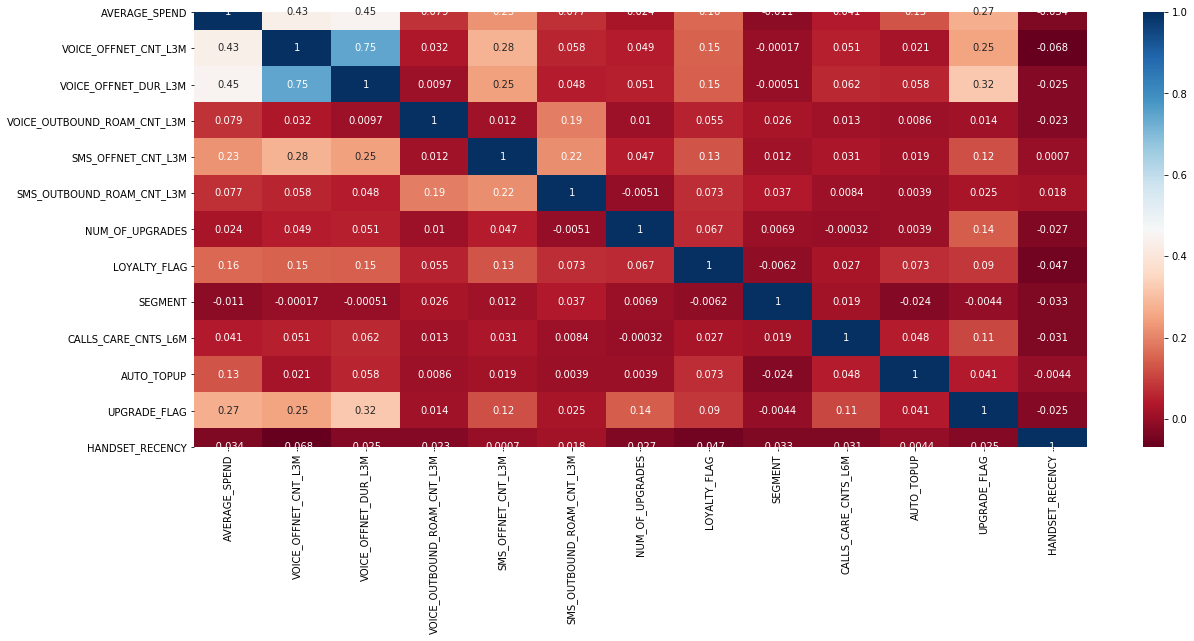

In [923]:
pyplot.figure(figsize=(20,8))
sns.heatmap(data.corr(),cmap='RdBu',annot=True);

#### Actions Taken:

- Converting Yes, No to 1,0 in LOYALTY_FLAG, AUTO_TOPUP and UPGRADE_FLAG.
- Created Handset recency feature using'HANDSET_FIRST_DATE','HANDSET_LATEST_DATE'.
- The 'HANDSET_FIRST_DATE' is more recent to 'HANDSET_LATEST_DATE' for 25 rows which creates negative records for the 'HANDSET_RECENCY' which are being removed considering it is a small number.
- No correlation is identified hence no further action required.

In [924]:
# Splitting the data into train and test
X = data.drop(['UPGRADE_FLAG'], axis=1)
y = data['UPGRADE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [925]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7227, 12)
(3098, 12)
(7227,)
(3098,)


In [926]:
print("Percentage of 0 class in train data:", len(y_train[y_train==0])*100/len(y_train))
print("Percentage of 1 class in train data:", len(y_train[y_train==1])*100/len(y_train))
print("Percentage of 0 class in train data:", len(y_test[y_test==0])*100/len(y_test))
print("Percentage of 1 class in train data:", len(y_test[y_test==1])*100/len(y_test))

Percentage of 0 class in train data: 96.62377196623773
Percentage of 1 class in train data: 3.3762280337622803
Percentage of 0 class in train data: 96.61071659134926
Percentage of 1 class in train data: 3.3892834086507424


# Model Building

In [939]:
#Training models and metrics for each
def fit_models(X_train, X_test, y_train, y_test, model_lr=False, model_rf=False,model_xgb=False, 
               model_lr_tuning=False, model_rf_xgb_tuning=False,
              model_lr_class_weight=None, check_overfitting=False):
    
    # Declaring the scoring parameter
    scoring = [ 'precision', 'precision_macro', 
               'recall', 'recall_macro',
               'f1', 'f1_macro']
    # Declaring parameters
    R_STATE = 42
    FOLDS = 5
    OVER_SAMPLING_STRATEGY = 0.3
    UNDER_SAMPLING_STRATEGY = 0.5
    OVER_UNDER_SAMPLING_STRATEGY = 0.5
    
    # Creating the required scaler and over/under sampling objects
    minmax_scaler = MinMaxScaler()
    over = SMOTE(sampling_strategy=OVER_SAMPLING_STRATEGY, random_state=R_STATE)
    under = RandomUnderSampler(sampling_strategy=UNDER_SAMPLING_STRATEGY, random_state=R_STATE)

    # Declaring the models tuples
    lr_model = ('LR', LogisticRegression(class_weight=model_lr_class_weight))
    rf_model = ('RF', RandomForestClassifier(random_state=R_STATE))
    xgb_model = ('XGB', XGBClassifier())
    # Declaring the models & other required lists
    models, names, dfs = [], [], []
    if(model_lr==True):
        models.append(lr_model)
    if(model_rf==True):
        models.append(rf_model)
    if(model_xgb==True):
        models.append(xgb_model)
        
    # Creating the KFold argument & other required lists
    kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=R_STATE)
    
    for name, model in models:
        
        # Defining the steps of the pipeline
        steps_lr = [('minmaxscaler', minmax_scaler), ('m', model)]
        steps_lr_tuning = [('o', over), ('u', under), ('minmaxscaler', minmax_scaler), ('m', model)]
        steps_rf_xgb = [('m', model)]
        steps_rf_xgb_tuning = [('o', over), ('u', under), ('m', model)]
    
        if name =='LR':
            if model_lr==True and model_lr_tuning==True:
                steps = steps_lr_tuning
            else:
                steps = steps_lr
        else:
            if (model_rf == True or model_xgb == True) and model_rf_xgb_tuning == True:
                steps = steps_rf_xgb_tuning
            else:
                steps = steps_rf_xgb
        
        pipeline = Pipeline(steps=steps)

        print("FOR MODEL:{}\n".format(name))
        
        model = pipeline.fit(X_train, y_train)

        if(check_overfitting==True):            
            y_pred_train = model.predict(X_train)        
            print("Confusion matrix:\n")
            cf_matrix_train = confusion_matrix(y_train, y_pred_train)
            print(cf_matrix_train)
            print("Classification report:\n",classification_report(y_train, y_pred_train))
        
        y_pred = model.predict(X_test)        
        print("Confusion matrix:\n")
        cf_matrix = confusion_matrix(y_test, y_pred)
        print(cf_matrix)
        print("Classification report:\n",classification_report(y_test, y_pred))

        # predict probabilities
        yhat = model.predict_proba(X_test)
        # retrieve just the probabilities for the positive class
        pos_probs = yhat[:, 1]
        # calculate the no skill line as the proportion of the positive class
        non_defaults = len(y_train[y_train==1]) / len(y_train)
        # plot the no skill precision-recall curve
        pyplot.plot([0, 1], [non_defaults, non_defaults], linestyle='--', label='Non Defaults')
        # calculate model precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test, pos_probs)
        auc_score = auc(recall, precision)
        print('PR AUC: %.3f' % auc_score)
        # plot the model precision-recall curve
        pyplot.plot(recall, precision, marker='.', label=name)
        # axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()
        
        # Using cross validation
        cv_results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=kfold, verbose=0)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
        # Printing means of cross validation results for each model
        print('Cross validation mean results for {}'.format(name))
        av_col = this_df.mean(axis=0)
        print(av_col)
    
    # Commenting code to print the dataframe of overall results, also add return type in definition
#     cv_results_df = pd.concat(dfs,ignore_index=True)
#     return cv_results_df
    return model

FOR MODEL:LR

Confusion matrix:

[[2992    1]
 [  86   19]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      2993
           1       0.95      0.18      0.30       105

    accuracy                           0.97      3098
   macro avg       0.96      0.59      0.64      3098
weighted avg       0.97      0.97      0.96      3098

PR AUC: 0.536


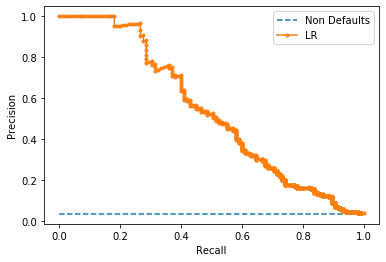

Cross validation mean results for LR
fit_time                0.096131
score_time              0.037368
test_precision          0.890000
test_precision_macro    0.930595
test_recall             0.151531
test_recall_macro       0.575407
test_f1                 0.257944
test_f1_macro           0.621490
dtype: float64
FOR MODEL:RF

Confusion matrix:

[[2990    3]
 [  75   30]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2993
           1       0.91      0.29      0.43       105

    accuracy                           0.97      3098
   macro avg       0.94      0.64      0.71      3098
weighted avg       0.97      0.97      0.97      3098

PR AUC: 0.528


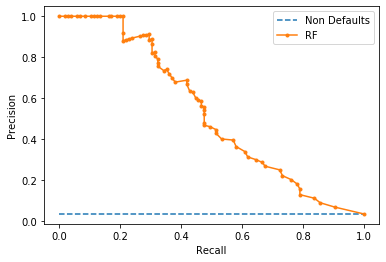

Cross validation mean results for RF
fit_time                1.497063
score_time              0.103982
test_precision          0.744747
test_precision_macro    0.858487
test_recall             0.184439
test_recall_macro       0.591002
test_f1                 0.293956
test_f1_macro           0.639344
dtype: float64
FOR MODEL:XGB

Confusion matrix:

[[2980   13]
 [  78   27]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2993
           1       0.68      0.26      0.37       105

    accuracy                           0.97      3098
   macro avg       0.82      0.63      0.68      3098
weighted avg       0.96      0.97      0.96      3098

PR AUC: 0.410


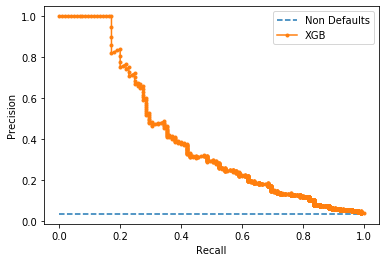

Cross validation mean results for XGB
fit_time                0.697216
score_time              0.052794
test_precision          0.575882
test_precision_macro    0.774420
test_recall             0.209184
test_recall_macro       0.601799
test_f1                 0.305795
test_f1_macro           0.644682
dtype: float64


Pipeline(steps=[('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [928]:
# Fitting models LR, RF, XGB without over/under sampling
fit_models(X_train, X_test, y_train, y_test, model_lr=True, model_rf=True, model_xgb=True)

FOR MODEL:LR

Confusion matrix:

[[6389  594]
 [  97  147]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      6983
           1       0.20      0.60      0.30       244

    accuracy                           0.90      7227
   macro avg       0.59      0.76      0.62      7227
weighted avg       0.96      0.90      0.93      7227

Confusion matrix:

[[2768  225]
 [  36   69]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      2993
           1       0.23      0.66      0.35       105

    accuracy                           0.92      3098
   macro avg       0.61      0.79      0.65      3098
weighted avg       0.96      0.92      0.93      3098

PR AUC: 0.505


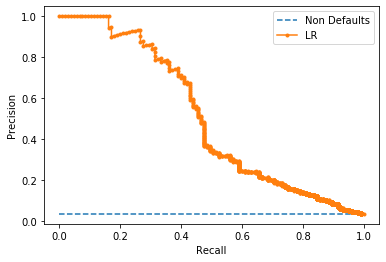

Cross validation mean results for LR
fit_time                0.114654
score_time              0.020797
test_precision          0.202211
test_precision_macro    0.593414
test_recall             0.590306
test_recall_macro       0.753837
test_f1                 0.300809
test_f1_macro           0.625295
dtype: float64


Pipeline(steps=[('o', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('u',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('minmaxscaler', MinMaxScaler()), ('m', LogisticRegression())])

In [940]:
# Fitting LR model with over/under sampling
fit_models(X_train, X_test, y_train, y_test, model_lr=True, model_lr_tuning=True, check_overfitting=True)

FOR MODEL:RF

Confusion matrix:

[[6912   71]
 [   0  244]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      6983
           1       0.77      1.00      0.87       244

    accuracy                           0.99      7227
   macro avg       0.89      0.99      0.93      7227
weighted avg       0.99      0.99      0.99      7227

Confusion matrix:

[[2941   52]
 [  60   45]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2993
           1       0.46      0.43      0.45       105

    accuracy                           0.96      3098
   macro avg       0.72      0.71      0.71      3098
weighted avg       0.96      0.96      0.96      3098

PR AUC: 0.414


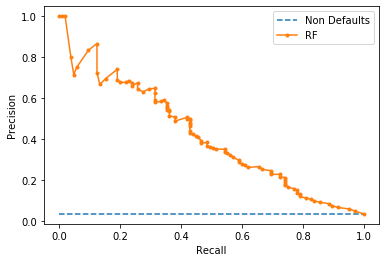

Cross validation mean results for RF
fit_time                1.145925
score_time              0.087566
test_precision          0.399890
test_precision_macro    0.689486
test_recall             0.401701
test_recall_macro       0.690181
test_f1                 0.399862
test_f1_macro           0.689365
dtype: float64


Pipeline(steps=[('o', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('u',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('m', RandomForestClassifier(random_state=42))])

In [941]:
# Fitting RF with over/under sampling and withnout lda or pca
fit_models(X_train, X_test, y_train, y_test, model_rf=True, model_rf_xgb_tuning=True, check_overfitting=True)

FOR MODEL:XGB

Confusion matrix:

[[6915   68]
 [   9  235]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      6983
           1       0.78      0.96      0.86       244

    accuracy                           0.99      7227
   macro avg       0.89      0.98      0.93      7227
weighted avg       0.99      0.99      0.99      7227

Confusion matrix:

[[2931   62]
 [  58   47]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2993
           1       0.43      0.45      0.44       105

    accuracy                           0.96      3098
   macro avg       0.71      0.71      0.71      3098
weighted avg       0.96      0.96      0.96      3098

PR AUC: 0.406


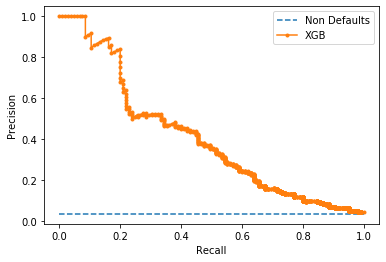

Cross validation mean results for XGB
fit_time                0.390931
score_time              0.024802
test_precision          0.355418
test_precision_macro    0.666664
test_recall             0.368793
test_recall_macro       0.672581
test_f1                 0.361247
test_f1_macro           0.669192
dtype: float64


Pipeline(steps=[('o', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('u',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               valid

In [942]:
# Fitting XGB with over/under sampling
fit_models(X_train, X_test, y_train, y_test, model_xgb=True, model_rf_xgb_tuning=True, check_overfitting=True)